# Toxic Comment Classification Challenge
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

## Download Dataset

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!mkdir data
!unzip train.csv.zip -d data/
!unzip test.csv.zip  -d data/
!unzip test_labels.csv.zip  -d data/
!unzip sample_submission.csv.zip  -d data/

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 93.7MB/s]
 73% 17.0M/23.4M [00:00<00:00, 19.2MB/s]
100% 23.4M/23.4M [00:00<00:00, 28.3MB/s]
 34% 9.00M/26.3M [00:00<00:01, 9.26MB/s]
100% 26.3M/26.3M [00:00<00:00, 28.6MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 99.4MB/s]
Archive:  train.csv.zip
  inflating: data/train.csv          
Archive:  test.csv.zip
  inflating: data/test.csv           
Archive:  test_labels.csv.zip
  inflating: data/test_labels.csv    
Archive:  sample_submission.csv.zip
  inflating: data/sample_submission.csv  


In [ ]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
test_labels_path = 'data/test_labels.csv'
subm_path = 'data/sample_submission.csv'

## NBSVM (Linear Baseline)
https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

### Load data

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test_labels = df_test_labels.set_index('id')

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Sentence lengths & class distribution

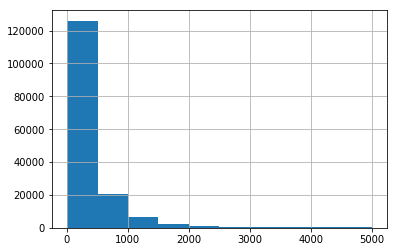

In [ ]:
comment_lens = df_train.comment_text.str.len()
comment_lens.hist()

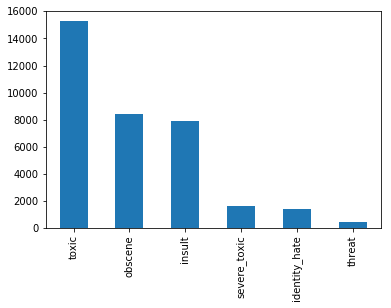

In [ ]:
df_train[label_cols].sum().sort_values(ascending=False).plot.bar()

### Feature Extraction

In [ ]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()


import time
start = time.time()

vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    # tokenizer=TreebankWordTokenizer().tokenize,
    tokenizer=tokenize,
    #token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2), # include 1-grams and 2-grams
    min_df=3, # only keep terms that appear in at least 2 documents
    max_df=0.9,
    max_features=None)

x_train = vectorizer.fit_transform(df_train['comment_text'])
x_test = vectorizer.transform(df_test['comment_text'])

print(time.time() - start)

64.11209464073181


### Modelling

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from scipy import sparse
from sklearn.utils.validation import check_X_y, check_is_fitted

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))

        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs, solver='liblinear', max_iter=100).fit(x_nb, y)
        return self

In [ ]:
predictions = np.zeros((len(df_test), len(label_cols)))

# | Train a seperate model for each dependent variable
for i, label in enumerate(label_cols):
    print('training', label)
    model = NbSvmClassifier(C=4, dual=True)
    model = model.fit(x_train, df_train[label])
    
    predictions[:,i] = model.predict_proba(x_test)[:,1]

training toxic
training severe_toxic


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


training obscene
training threat


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


training insult
training identity_hate


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Evaluation

#### Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

model = NbSvmClassifier(C=4, dual=True)

scores = []
for label in label_cols:
    cv_score = np.mean(cross_val_score(model, x_train, df_train[label], cv=3, scoring='roc_auc'))
    print(f'{label} score: {cv_score}', label)
    scores.append(cv_score)
    
print('Total CV score is {}'.format(np.mean(scores)))

toxic score: 0.9752707644224539 toxic


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


severe_toxic score: 0.9791386669269002 severe_toxic


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


obscene score: 0.98801672274422 obscene


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


threat score: 0.9799048702507259 threat


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


insult score: 0.9772779775226743 insult


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


identity_hate score: 0.9700836621960347 identity_hate
Total CV score is 0.9782821106771681


#### Evaluation on test-set 

In [ ]:
df_pred = pd.DataFrame(predictions, columns=label_cols)
df_pred = pd.concat([df_test, df_pred], axis=1)
df_pred = df_pred.set_index('id')

df_pred.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.999996,0.056510,0.999964,0.002058,0.986571,0.362104
0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.006075,0.000966,0.004201,0.000120,0.005512,0.000392
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.009947,0.000812,0.004720,0.000098,0.004124,0.000283
00017563c3f7919a,":If you have a look back at the source, the in...",0.001160,0.000283,0.001051,0.000240,0.001028,0.000225
00017695ad8997eb,I don't anonymously edit articles at all.,0.016037,0.000392,0.001696,0.000138,0.002533,0.000301


In [ ]:
from sklearn.metrics import roc_auc_score
df_test_labels.head()

idxs_used_for_eval = df_test_labels[df_test_labels['toxic'] != -1].index
roc_auc_score(df_test_labels.loc[idxs_used_for_eval, label_cols], df_pred.loc[idxs_used_for_eval, label_cols])

0.9728629768281053

In [ ]:
subm = pd.read_csv(subm_path)

submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(predictions, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission.csv -m "nbsvm"

## CNN

In [ ]:
!pip install tensorflow==2.0.0

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
keras = tf.keras

print(tf.__version__)

2.0.0


In [ ]:
embed_size = 300
max_features = 100000
max_len = 150

### Load data

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df = pd.read_csv(train_path)
nr_train_samples = int(0.9*len(df))

df_train = df.iloc[:nr_train_samples]
df_val = df.iloc[nr_train_samples:]

df_test = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test = pd.concat([df_test, df_test_labels], axis=1)
# df_test = df_test[df_test['toxic'] != -1]

df_test.head()

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,00017695ad8997eb,-1,-1,-1,-1,-1,-1


### Preprocessing

In [ ]:
text_col = "comment_text"

df_train[text_col] = df_train[text_col].fillna("no comment")
df_val[text_col] = df_val[text_col].fillna("no comment")
df_test[text_col] = df_test[text_col].fillna("no comment")

df_train[text_col] = df_train[text_col].str.lower()
df_val[text_col] = df_val[text_col].str.lower()
df_test[text_col] = df_test[text_col].str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = max_features, lower = True)
tokenizer.fit_on_texts(df_train[text_col])

x_train = tokenizer.texts_to_sequences(df_train[text_col])
y_train = df_train[label_cols].values

x_val = tokenizer.texts_to_sequences(df_val[text_col])
y_val = df_val[label_cols].values

x_test = tokenizer.texts_to_sequences(df_test[text_col])
y_test = df_test[label_cols].values

x_train = pad_sequences(x_train, maxlen = max_len)
x_val = pad_sequences(x_val, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

### Word Embeddings
https://nlp.stanford.edu/projects/glove/

In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip


In [ ]:
embedding_path = './glove.840B.300d.txt'

!head -5 {embedding_path}

, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.3

In [ ]:
embedding_index = dict()

with open(embedding_path, 'r') as fp:
    for line in fp:
        values = line.strip().split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = embedding

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: 
        continue
        
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

### Modelling

In [ ]:
from tensorflow.keras.layers import Embedding

def embedding_test(embed_size, embedding_matrix):
    return tf.keras.Sequential([
        Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = False)              
    ])

emb = embedding_test(embed_size, embedding_matrix)
emb(x_val)

In [ ]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential


def create_model_baseline(lr, nr_classes, max_features, embed_size, embedding_matrix, dropout=0.0, lr_decay=0.0):
    model = Sequential()
    model.add(Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = False))
    model.add(Dropout(dropout))
    model.add(Conv1D(250, 3, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nr_classes, activation='sigmoid'))
    
    model.compile(loss = "binary_crossentropy", 
                  optimizer = tf.keras.optimizers.Adam(lr = lr, decay = lr_decay), 
                  metrics = ["accuracy"])

    return model


def create_model_baseline2():
    seq = Input(shape=(max_len,), name='seq')
    l = Embedding(max_features, embedding_dims, weights=[embedding_matrix])(seq)
    l = SpatialDropout1D(0.4)(l)
    c2 = Conv1D(embedding_dims,2, activation='relu')(l)
    c3 = Conv1D(embedding_dims,3, activation='relu')(l)
    c4 = Conv1D(embedding_dims,4, activation='relu')(l)
    c5 = Conv1D(embedding_dims,5, activation='relu')(l)
    max_pool2 = GlobalMaxPooling1D()(c2)
    max_pool3 = GlobalMaxPooling1D()(c3)
    max_pool4 = GlobalMaxPooling1D()(c4)
    max_pool5 = GlobalMaxPooling1D()(c5)
    conc = concatenate([max_pool2,max_pool3,max_pool4,max_pool5])
    conc = Dense(36)(conc)
    output = Dense(6, activation='sigmoid', name='output')(conc)
    
    model = Model(inputs=[seq], outputs=output)
    
    model.compile(loss = "binary_crossentropy", 
              optimizer = tf.keras.optimizers.Adam(lr = lr, decay = lr_decay), 
              metrics = ["accuracy"])
    return model

def create_model_baseline3(lr, nr_classes, max_features, embed_size, embedding_matrix):
    inp = Input(shape = (max_len,))
    x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x= Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = Dropout(0.2)(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(nr_classes, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=output)

    
    model.compile(loss = "binary_crossentropy", 
                  optimizer = tf.keras.optimizers.Adam(lr), 
                  metrics = ["accuracy"])

    return model


def create_model(lr, nr_classes, max_features, embed_size, embedding_matrix, gru_units=128, dropout=0.0, lr_decay=0.0):
    inp = Input(shape = (max_len,))
    # x = Embedding(max_features, embed_size, trainable = True)(inp)
    x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x = SpatialDropout1D(dropout)(x)
    x = Bidirectional(GRU(gru_units, return_sequences = True))(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    #x = keras.layers.Dropout(dropout)(x)
    #x = keras.layers.Dense(256, activation="relu")(x)
    # x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(nr_classes, activation="sigmoid")(x)
    
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", 
                  optimizer = tf.keras.optimizers.Adam(lr = lr, decay = lr_decay), 
                  metrics = ["accuracy"])

    return model

In [ ]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score


class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))


ra_val = RocAucEvaluation(validation_data=(x_val, y_val), interval = 1)

model = create_model(lr=1e-3, nr_classes=len(label_cols), max_features=max_features, embed_size=embed_size, embedding_matrix=embedding_matrix, dropout=0.2)
# model = create_model_baseline(lr=1e-3, nr_classes=len(label_cols), max_features=max_features, embed_size=embed_size, embedding_matrix=embedding_matrix, dropout=0.2)

history = model.fit(x_train, 
                    y_train, 
                    batch_size = 128, 
                    epochs = 4, 
                    validation_data = (x_val, y_val), 
                    verbose = 1, 
                    callbacks = [ra_val])

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0550 - accuracy: 0.9802
 ROC-AUC - epoch: 1 - score: 0.986031
143613/143613 [==============================] - 1873s 13ms/sample - loss: 0.0550 - accuracy: 0.9802 - val_loss: 0.0455 - val_accuracy: 0.9827
Epoch 2/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0430 - accuracy: 0.9835
 ROC-AUC - epoch: 2 - score: 0.987890
143613/143613 [==============================] - 1878s 13ms/sample - loss: 0.0430 - accuracy: 0.9835 - val_loss: 0.0431 - val_accuracy: 0.9831
Epoch 3/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0399 - accuracy: 0.9844
 ROC-AUC - epoch: 3 - score: 0.988351
143613/143613 [==============================] - 1866s 13ms/sample - loss: 0.0400 - accuracy: 0.9843 - val_loss: 0.0427 - val_accuracy: 0.9836
Epoch 4/4
143488/143613 [============================>.] - ETA: 1s - loss: 0.0375 - accuracy: 0.9853
 R

### Evaluation

In [ ]:
y_pred = model.predict(x_test, batch_size=128, verbose=0)

df_pred = pd.DataFrame(y_pred, columns=label_cols)
idxs_used_for_eval = df_test_labels[df_test_labels['toxic'] != -1].index

In [ ]:
roc_auc_score(df_test_labels.loc[idxs_used_for_eval, label_cols], y_pred[idxs_used_for_eval])

0.9823886064926209

In [ ]:
subm = pd.read_csv(subm_path)

submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(y_pred, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission.csv -m "gru-cnn"

100% 13.7M/13.7M [00:04<00:00, 3.37MB/s]
Successfully submitted to Toxic Comment Classification Challenge

## Deep Learning Approach 2: BERT Transfer Learning

For multiclass classification, use sigmoid instead of softmax as output layer, combined with sigmoid_cross_entropy_with_logits loss?

Use fast.ai library (based on PyTorch) - much easier than with Tensorflow.

Main sources: https://github.com/huggingface/transformers/blob/04c69db399b2ab9e3af872ce46730fbd9f17aec3/examples/run_tf_glue.py

[Sequence Classification with Transformers](https://colab.research.google.com/drive/1l39vWjZ5jRUimSQDoUcuWGIoNjLjA2zu#scrollTo=8aihC2QV6IXk)

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  # Load the TensorBoard extension
  %load_ext tensorboard
except Exception:
  pass

TensorFlow 2.x selected.


In [ ]:
!pip install transformers

     |████████████████████████████████| 317kB 2.7MB/s 
     |████████████████████████████████| 645kB 40.8MB/s 
     |████████████████████████████████| 860kB 38.5MB/s 
     |████████████████████████████████| 1.0MB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=36880f3d318f1f3d66a59e2ef636dc397ffc6ae00ace601a078047e2aa8e6f15
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_datasets
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig, glue_convert_examples_to_features, BertForSequenceClassification, glue_processors
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

### Load Dataset

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df = pd.read_csv(train_path)
nr_train_samples = int(0.9*len(df))

df_train = df.iloc[:nr_train_samples]
df_val = df.iloc[nr_train_samples:]

df_train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


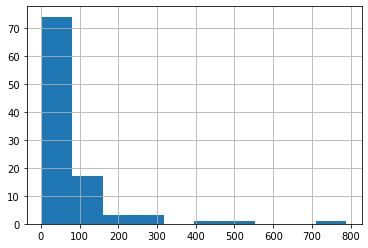

In [ ]:
df_train = df_train.sample(100)
df_val = df_val.sample(100)

comment_lens = df_train.comment_text.str.count(' ') + 1
comment_lens.hist()

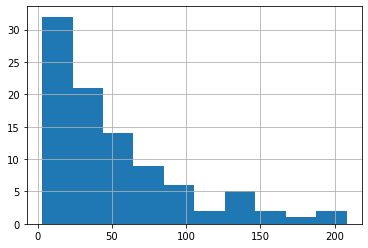

In [ ]:
df_train = df_train.loc[df_train.comment_text.str.count(' ') + 1 < 220]
df_val = df_val.loc[df_val.comment_text.str.count(' ') + 1 < 220]

comment_lens = df_train.comment_text.str.count(' ') + 1
comment_lens.hist()

In [ ]:
from transformers import InputFeatures, InputExample

def convert_examples_to_features(examples, tokenizer,
                                max_length=512,
                                pad_on_left=False,
                                pad_token=0,
                                pad_token_segment_id=0,
                                mask_padding_with_zero=True):
    """
    Note: Just adapted the function glue_convert_examples_to_features, 
    to support tensors as label instead of scalar
    """

    features = []
    for (ex_index, example) in enumerate(examples):
        example = InputExample(example['idx'].numpy(),
                            example['sentence1'].numpy().decode('utf-8'),
                            example['sentence2'].numpy().decode('utf-8'),
                            example['label'].numpy())

        inputs = tokenizer.encode_plus(
            example.text_a,
            example.text_b,
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)

        label = example.label

        features.append(
                InputFeatures(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              label=label))

    def gen():
        for ex in features:
            yield  ({'input_ids': ex.input_ids,
                    'attention_mask': ex.attention_mask,
                    'token_type_ids': ex.token_type_ids},
                    ex.label)
            
    return tf.data.Dataset.from_generator(gen,
        ({'input_ids': tf.int32,
            'attention_mask': tf.int32,
            'token_type_ids': tf.int32},
            tf.int64),
        ({'input_ids': tf.TensorShape([None]),
            'attention_mask': tf.TensorShape([None]),
            'token_type_ids': tf.TensorShape([None])},
            tf.TensorShape([None])))

In [ ]:
def convert_to_example(id, sentence, label):
    return {'idx': tf.dtypes.cast(id, tf.dtypes.int32), 'label': label, 'sentence1': sentence, 'sentence2': ""}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

train_dataset = tf.data.Dataset.from_tensor_slices((df_train.index.values, df_train['comment_text'].values, df_train[label_cols].values))
train_dataset = train_dataset.map(convert_to_example)

train_dataset = convert_examples_to_features(train_dataset, tokenizer, 220)

for data, label in train_dataset.take(1):
    print(label)

100%|██████████| 213450/213450 [00:00<00:00, 389333.78B/s]


tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)


In [ ]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import numpy as np

class RocAucEvaluation(Callback):
    def __init__(self, validation_dataset, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.val_dataset = validation_dataset
        all_labels = []
        for f, labels in validation_dataset:
            all_labels.append(labels.numpy())

        self.all_labels = np.concatenate(all_labels, axis=0)
        

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.val_dataset, verbose=0)
            for i in range(y_pred.shape[1]):
                score = roc_auc_score(self.all_labels[:,i], y_pred[:,i])
                print("\n i ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))


In [ ]:
# script parameters
BATCH_SIZE = 16
EVAL_BATCH_SIZE = BATCH_SIZE
USE_XLA = False
USE_AMP = False
EPOCHS = 5

num_labels = 6

tf.config.optimizer.set_jit(USE_XLA)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": USE_AMP})

# Load tokenizer and model from pretrained model/vocabulary. Specify the number of labels to classify (2+: classification, 1: regression)
config = BertConfig.from_pretrained("bert-base-cased", num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', config=config)

# Create Data Pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.index.values, df_train['comment_text'].values, df_train[label_cols].values))
train_dataset = train_dataset.map(convert_to_example)

valid_dataset = tf.data.Dataset.from_tensor_slices((df_val.index.values, df_val['comment_text'].values, df_val[label_cols].values))
valid_dataset = valid_dataset.map(convert_to_example)

train_examples = len(df_train)
valid_examples = len(df_val)

train_dataset = convert_examples_to_features(train_dataset, tokenizer, 220)
valid_dataset = convert_examples_to_features(valid_dataset, tokenizer, 220)

train_dataset = train_dataset.shuffle(128).batch(BATCH_SIZE).repeat(-1)
valid_dataset = valid_dataset.batch(EVAL_BATCH_SIZE)

ra_val = RocAucEvaluation(validation_dataset=valid_dataset, interval = 1)

# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule 
opt = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08)

# Loss: TFBertForSequenceClassification has no sigmoid activation in output layer --> set from_logits=True
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train and evaluate using tf.keras.Model.fit()
train_steps = train_examples//BATCH_SIZE
valid_steps = valid_examples//EVAL_BATCH_SIZE

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    steps_per_epoch=train_steps,
                    validation_data=valid_dataset, 
                    validation_steps=valid_steps, 
                    callbacks = [ra_val])


Train for 5 steps, validate for 5 steps
Epoch 1/5
4/5 [=======================>......] - ETA: 7s - loss: 0.4684 - accuracy: 0.9375 
 i ROC-AUC - epoch: 1 - score: 0.645503

 i ROC-AUC - epoch: 1 - score: 0.836957

 i ROC-AUC - epoch: 1 - score: 0.455556


ValueError: ignored

### Evaluation


In [ ]:
df_test = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test = pd.concat([df_test, df_test_labels], axis=1)
df_test = df_test[df_test['toxic'] != -1]

In [ ]:
df_test = df_test.sample(2000)
df_test['comment_text'] = df_test['comment_text'].str.slice(0,512)

In [ ]:
test_batch_size = 8
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.index.values, df_test['comment_text'].values, df_test[label_cols].values))
test_dataset = test_dataset.map(convert_to_example)

test_dataset = convert_examples_to_features(test_dataset, tokenizer, 512)
test_dataset = test_dataset.batch(test_batch_size)

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict(test_dataset, verbose=1, workers=4, steps=len(df_test)//test_batch_size)
y_pred = tf.keras.activations.sigmoid(y_pred)

roc_auc_score(df_test[label_cols], y_pred)

250/250 [==============================] - 52s 209ms/step


0.7013244147372028